<a href="https://colab.research.google.com/github/tallerzalan/Applied-Machine-Learning/blob/main/NNs/Exercise_7_opt_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises - optimization and regularization

1. Use the fashion MNIST data. Build a baseline model and evaluate its performance. Go through (one at a time) early stopping, weight regularization, dropout, and batch normalization, and see how these change the performance of your model. Which method is - in isolation - best when applied to your model?
1. Now combine the methods, such as applying early stopping *and* dropout simultaneously. Optimally, try to work through all combinations (also of more than 2 methods).
1. Using a validation set and what you learned in (2), aim for the best model possible (preferably *without* using convolutional layers).

**Note**: You may want to use:
1. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
1. https://www.tensorflow.org/api_docs/python/tf/keras/regularizers
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

**See slides for more details!**

# Setup

Consider implementing a validation set.

In [ ]:
import tensorflow as tf
from keras.utils import to_categorical

seed = 42
tf.random.set_seed(seed)

import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def build_model(size,
                activation,
                weight_regularizer,
                dropout,
                batch_norm):
  
  layers = [tf.keras.layers.Flatten(input_shape = (28, 28))]
    
  number_of_layers = size
  number_of_neurons = size ** 2 * 4
    
  for i in range(number_of_layers):
    layers.append(tf.keras.layers.Dense(number_of_neurons,
                                        activation = activation,
                                        kernel_regularizer = weight_regularizer))
    if batch_norm:
      layers.append(tf.keras.layers.BatchNormalization())
        
    if dropout:
      layers.append(tf.keras.layers.Dropout(0.2))

  layers.append(tf.keras.layers.Dense(10, activation = 'softmax'))
    
  model = tf.keras.models.Sequential(layers)
    
  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy'])
    
  return model


def plot_histories(histories,
                   names,
                   measure,
                   xlim_max = 40,
                   ylim_min = 0,
                   ylim_max = 0):
  
  measure_to_pretty = {'loss': 'loss',
                       'accuracy': 'accuracy'}
  
  number_of_histories = len(histories)
  
  fig = plt.figure(figsize = plt.figaspect(0.05 * number_of_histories))
    
  for i in range(number_of_histories):
    ax = fig.add_subplot(1, number_of_histories, i + 1)
    
    ax.plot(histories[i].history[f'val_{measure}'],
            label = f'Test {measure_to_pretty[measure]}, {names[i]}')
    
    ax.plot(histories[i].history[f'{measure}'],
            label = f'Train {measure_to_pretty[measure]}, {names[i]}')
    
    plt.xlabel('Epoch')
    plt.ylabel(measure)
    
    plt.legend()
    plt.xlim(0, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    
    #plt.gca().set_aspect('equal', adjustable = 'box')
    plt.draw()

  plt.show()

# Exercise 1

Use the fashion MNIST data. Build a baseline model and evaluate its performance. Go through (one at a time) early stopping, weight regularization, dropout, and batch normalization, and see how these change the performance of your model. Which method is - in isolation - best when applied to your model?

In [ ]:
results = pd.DataFrame(columns = ['loss', 'accuracy'])

In [ ]:
model_baseline = build_model(5, 'relu', None, False, False)

history_baseline = model_baseline.fit(X_train,
                                      y_train,
                                      validation_data = (X_test, y_test),
                                      epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 11s 4ms/step - loss: 0.5122 - accuracy: 0.8138 - val_loss: 0.4322 - val_accuracy: 0.8452
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3770 - accuracy: 0.8610 - val_loss: 0.4374 - val_accuracy: 0.8471
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3429 - accuracy: 0.8736 - val_loss: 0.3896 - val_accuracy: 0.8598
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3214 - accuracy: 0.8813 - val_loss: 0.3677 - val_accuracy: 0.8677
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3057 - accuracy: 0.8858 - val_loss: 0.3831 - val_accuracy: 0.8609
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2908 - accuracy: 0.8912 - val_loss: 0.3875 - val_accuracy: 0.8646
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2820 - accuracy: 0.8955 - val_loss: 0.3697 - val_accuracy

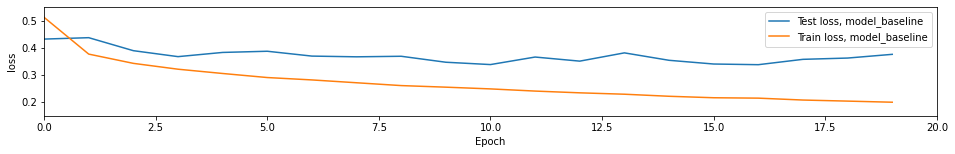

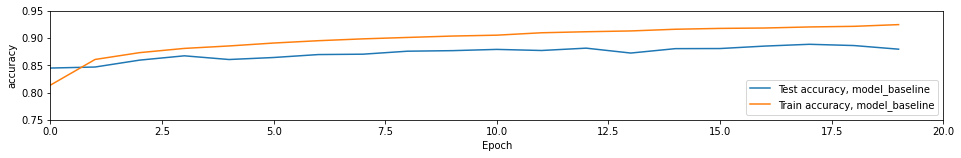

In [ ]:
plot_histories(histories = [history_baseline],
               names = ['model_baseline'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.15,
               ylim_max = 0.55)

plot_histories(histories = [history_baseline],
               names = ['model_baseline'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.75,
               ylim_max = 0.95)

In [ ]:
baseline_results = model_baseline.evaluate(X_test, y_test)

results.loc['baseline'] = baseline_results

313/313 [==============================] - 1s 2ms/step - loss: 0.3761 - accuracy: 0.8799
              loss  accuracy
baseline  0.376129    0.8799


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)

model_early = build_model(5, 'relu', None, False, False)

history_early = model_early.fit(X_train,
                                y_train,
                                validation_data = (X_test, y_test),
                                epochs = 20,
                                callbacks = [early_stopping])

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5124 - accuracy: 0.8137 - val_loss: 0.4185 - val_accuracy: 0.8503
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3801 - accuracy: 0.8594 - val_loss: 0.4488 - val_accuracy: 0.8474
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3472 - accuracy: 0.8717 - val_loss: 0.4257 - val_accuracy: 0.8420
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3244 - accuracy: 0.8809 - val_loss: 0.3924 - val_accuracy: 0.8583
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3058 - accuracy: 0.8869 - val_loss: 0.3774 - val_accuracy: 0.8665
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2906 - accuracy: 0.8925 - val_loss: 0.3784 - val_accuracy: 0.8618
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2826 - accuracy: 0.8956 - val_loss: 0.3776 - val_accuracy:

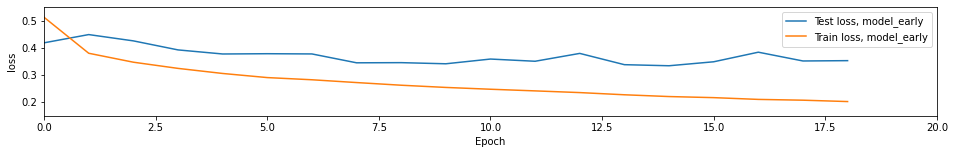

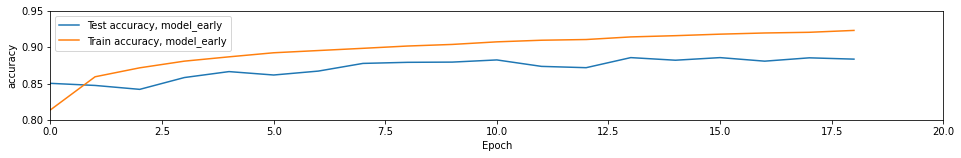

In [ ]:
plot_histories(histories = [history_early],
               names = ['model_early'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.15,
               ylim_max = 0.55)

plot_histories(histories = [history_early],
               names = ['model_early'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.8,
               ylim_max = 0.95)

In [ ]:
early_results = model_early.evaluate(X_test, y_test)

results.loc['early_stopping'] = early_results

313/313 [==============================] - 1s 2ms/step - loss: 0.3529 - accuracy: 0.8837


In [ ]:
model_regularized = build_model(5, 'relu', tf.keras.regularizers.l2(0.001), False, False)

history_regularized = model_regularized.fit(X_train,
                                            y_train,
                                            validation_data = (X_test, y_test),
                                            epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8056 - accuracy: 0.8064 - val_loss: 0.6490 - val_accuracy: 0.8435
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5955 - accuracy: 0.8462 - val_loss: 0.6059 - val_accuracy: 0.8406
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5431 - accuracy: 0.8540 - val_loss: 0.5542 - val_accuracy: 0.8436
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5126 - accuracy: 0.8597 - val_loss: 0.5439 - val_accuracy: 0.8472
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4966 - accuracy: 0.8621 - val_loss: 0.5152 - val_accuracy: 0.8554
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4829 - accuracy: 0.8653 - val_loss: 0.5172 - val_accuracy: 0.8503
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4744 - accuracy: 0.8660 - val_loss: 0.5135 - val_accuracy:

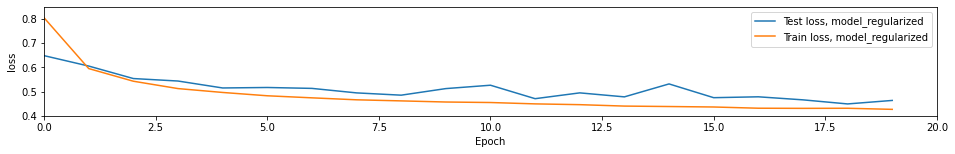

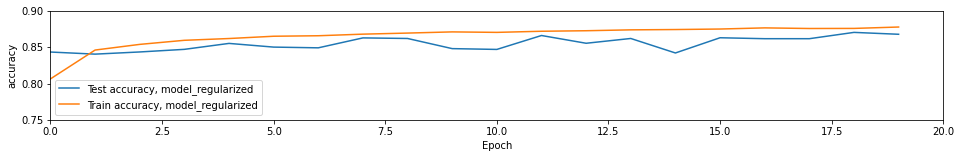

In [ ]:
plot_histories(histories = [history_regularized],
               names = ['model_regularized'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.4,
               ylim_max = 0.85)

plot_histories(histories = [history_regularized],
               names = ['model_regularized'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.75,
               ylim_max = 0.9)

In [ ]:
regularized_results = model_regularized.evaluate(X_test, y_test)

results.loc['l2_regularized'] = regularized_results

313/313 [==============================] - 1s 2ms/step - loss: 0.4636 - accuracy: 0.8680


In [ ]:
model_dropout = build_model(5, 'relu', None, True, False)

history_dropout = model_dropout.fit(X_train,
                                    y_train,
                                    validation_data = (X_test, y_test),
                                    epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.6948 - accuracy: 0.7485 - val_loss: 0.4601 - val_accuracy: 0.8389
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4793 - accuracy: 0.8317 - val_loss: 0.4351 - val_accuracy: 0.8476
Epoch 3/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4460 - accuracy: 0.8436 - val_loss: 0.4169 - val_accuracy: 0.8421
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4202 - accuracy: 0.8517 - val_loss: 0.3903 - val_accuracy: 0.8616
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4067 - accuracy: 0.8573 - val_loss: 0.3819 - val_accuracy: 0.8652
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3894 - accuracy: 0.8625 - val_loss: 0.3882 - val_accuracy: 0.8559
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3857 - accuracy: 0.8628 - val_loss: 0.4140 - val_accuracy:

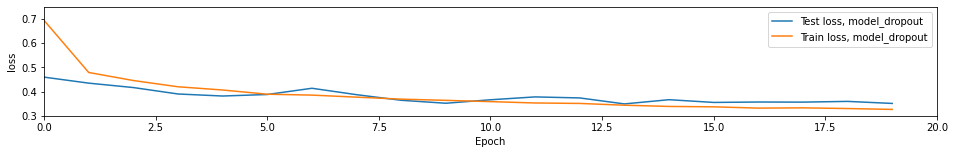

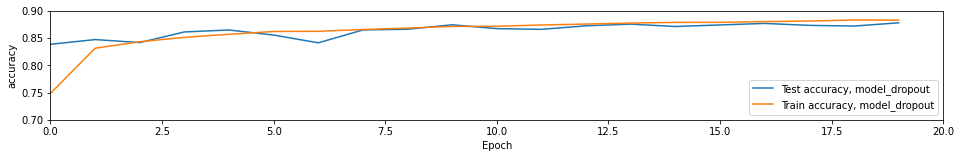

In [ ]:
plot_histories(histories = [history_dropout],
               names = ['model_dropout'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.3,
               ylim_max = 0.75)

plot_histories(histories = [history_dropout],
               names = ['model_dropout'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.7,
               ylim_max = 0.9)

In [ ]:
dropout_results = model_dropout.evaluate(X_test, y_test)

results.loc['dropout'] = regularized_results

313/313 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.8784


In [ ]:
model_batch_norm = build_model(5, 'relu', None, False, True)

history_batch_norm = model_dropout.fit(X_train,
                                       y_train,
                                       validation_data = (X_test, y_test),
                                       epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3261 - accuracy: 0.8835 - val_loss: 0.3644 - val_accuracy: 0.8764
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3241 - accuracy: 0.8840 - val_loss: 0.3651 - val_accuracy: 0.8762
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3220 - accuracy: 0.8844 - val_loss: 0.3352 - val_accuracy: 0.8824
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3236 - accuracy: 0.8848 - val_loss: 0.3433 - val_accuracy: 0.8814
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3146 - accuracy: 0.8866 - val_loss: 0.3572 - val_accuracy: 0.8790
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3135 - accuracy: 0.8882 - val_loss: 0.3441 - val_accuracy: 0.8766
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3149 - accuracy: 0.8877 - val_loss: 0.3517 - val_accuracy:

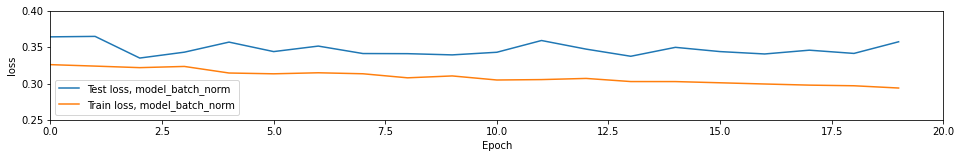

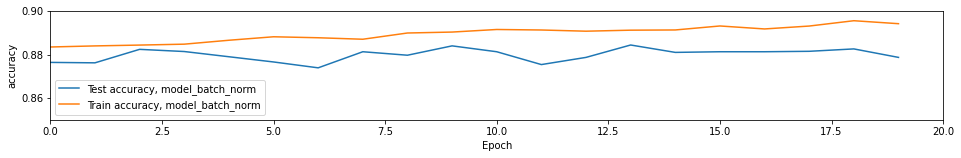

In [ ]:
plot_histories(histories = [history_batch_norm],
               names = ['model_batch_norm'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.25,
               ylim_max = 0.4)

plot_histories(histories = [history_batch_norm],
               names = ['model_batch_norm'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.85,
               ylim_max = 0.9)

In [ ]:
batch_norm_results = model_batch_norm.evaluate(X_test, y_test)

results.loc['batch_norm'] = batch_norm_results

313/313 [==============================] - 1s 3ms/step - loss: 2.3315 - accuracy: 0.0854


# Exercise 2

Now combine the methods, such as applying early stopping *and* dropout simultaneously. Optimally, try to work through all combinations (also of more than 2 methods).

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)

model_early_dropout = build_model(5, 'relu', None, True, False)

history_early_dropout = model_early_dropout.fit(X_train,
                                                y_train,
                                                validation_data = (X_test, y_test),
                                                epochs = 20,
                                                callbacks = [early_stopping])

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.6910 - accuracy: 0.7473 - val_loss: 0.4750 - val_accuracy: 0.8300
Epoch 2/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4904 - accuracy: 0.8279 - val_loss: 0.4335 - val_accuracy: 0.8513
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4548 - accuracy: 0.8413 - val_loss: 0.4122 - val_accuracy: 0.8521
Epoch 4/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4341 - accuracy: 0.8466 - val_loss: 0.4076 - val_accuracy: 0.8569
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4147 - accuracy: 0.8521 - val_loss: 0.3944 - val_accuracy: 0.8622
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4016 - accuracy: 0.8593 - val_loss: 0.4115 - val_accuracy: 0.8491
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3921 - accuracy: 0.8608 - val_loss: 0.3903 - val_accuracy:

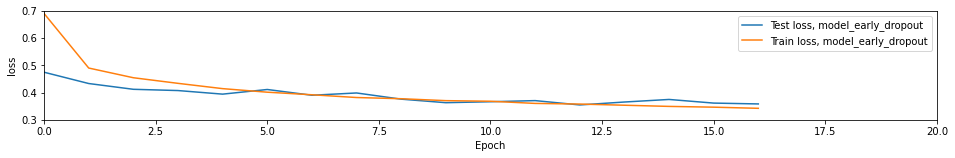

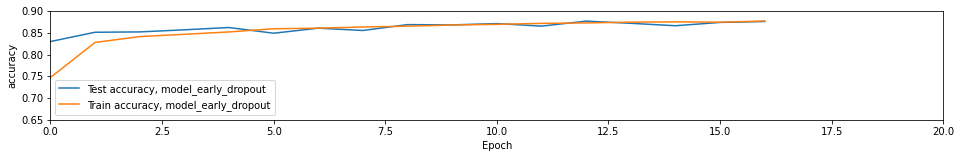

In [ ]:
plot_histories(histories = [history_early_dropout],
               names = ['model_early_dropout'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.3,
               ylim_max = 0.7)

plot_histories(histories = [history_early_dropout],
               names = ['model_early_dropout'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.65,
               ylim_max = 0.9)

In [ ]:
early_dropout_results = model_early_dropout.evaluate(X_test, y_test)

results.loc['early_stopping_dropout'] = early_dropout_results

313/313 [==============================] - 1s 2ms/step - loss: 0.3584 - accuracy: 0.8760


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)

model_early_regularized = build_model(5, 'relu', tf.keras.regularizers.l2(0.001), True, False)

history_early_regularized = model_early_regularized.fit(X_train,
                                                        y_train,
                                                        validation_data = (X_test, y_test),
                                                        epochs = 20,
                                                        callbacks = [early_stopping])

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0274 - accuracy: 0.7415 - val_loss: 0.7318 - val_accuracy: 0.8283
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7116 - accuracy: 0.8150 - val_loss: 0.6475 - val_accuracy: 0.8240
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6587 - accuracy: 0.8247 - val_loss: 0.6032 - val_accuracy: 0.8401
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6367 - accuracy: 0.8306 - val_loss: 0.5919 - val_accuracy: 0.8415
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6290 - accuracy: 0.8325 - val_loss: 0.5915 - val_accuracy: 0.8392
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6183 - accuracy: 0.8347 - val_loss: 0.6295 - val_accuracy: 0.8340
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6160 - accuracy: 0.8366 - val_loss: 0.6024 - val_accuracy:

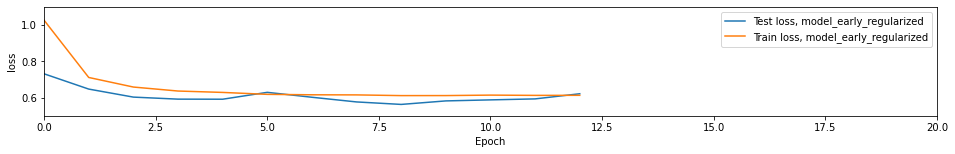

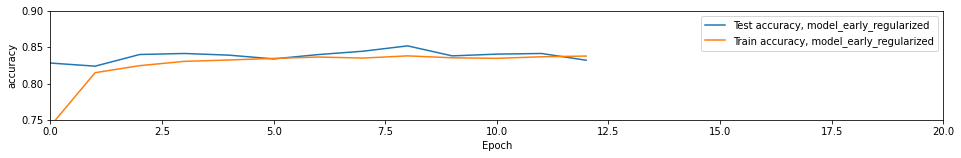

In [ ]:
plot_histories(histories = [history_early_regularized],
               names = ['model_early_regularized'],
               measure = 'loss',
               xlim_max = 20,
               ylim_min = 0.5,
               ylim_max = 1.1)

plot_histories(histories = [history_early_regularized],
               names = ['model_early_regularized'],
               measure = 'accuracy',
               xlim_max = 20,
               ylim_min = 0.75,
               ylim_max = 0.9)

In [ ]:
early_regularized_results = model_early_regularized.evaluate(X_test, y_test)

results.loc['early_stopping_regularized'] = early_regularized_results

313/313 [==============================] - 1s 3ms/step - loss: 0.6217 - accuracy: 0.8322


# Exercise 3

Using a validation set and what you learned in (2), aim for the best model possible (preferably *without* using convolutional layers).

In [ ]:
min_loss = results.sort_values('loss')

print(min_loss)

                                loss  accuracy
early_stopping              0.352908    0.8837
early_stopping_dropout      0.358370    0.8760
baseline                    0.376129    0.8799
l2_regularized              0.463604    0.8680
dropout                     0.463604    0.8680
early_stopping_regularized  0.621670    0.8322
batch_norm                  2.331452    0.0854


In [ ]:
max_accuracy = results.sort_values('accuracy', ascending = False)

print(max_accuracy)

                                loss  accuracy
early_stopping              0.352908    0.8837
baseline                    0.376129    0.8799
early_stopping_dropout      0.358370    0.8760
l2_regularized              0.463604    0.8680
dropout                     0.463604    0.8680
early_stopping_regularized  0.621670    0.8322
batch_norm                  2.331452    0.0854
